In [1]:
import pandas as pd

# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 
df = pd.read_csv('house_data_census.csv')

In [2]:
df = df[df.tracts != '0']
df = df.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.astype(float)
df = df.replace(np.nan, 0)
df['compared_to_neighbors'] = df['sqft_living']/df['sqft_living15']
df['lot_compared_to_neighbors'] = df['sqft_lot']/df['sqft_lot15']
df['empty_lot_space'] =  df['sqft_living'] / df['sqft_lot']


In [3]:
df.columns

Index(['field_1', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'tracts',
       'ESL_Score', 'Income_Sco', 'RE_Score', 'TotalScore', 'WeightedTo',
       'PercentESL', 'MedianHous', 'PercentPOC', 'compared_to_neighbors',
       'lot_compared_to_neighbors', 'empty_lot_space'],
      dtype='object')

In [4]:
df['tract_num'] = df.tracts.str[5:]
df.tract_num  = df.tract_num.astype(int)

In [5]:
X = df.copy()
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)


In [6]:
numeric = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'grade', 'condition', 'sqft_above', 'bathrooms', 'bedrooms', 'yr_built', 'compared_to_neighbors', 'empty_lot_space']

cats = ['tract_num']

In [7]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[cats])

X_train_encoded = ohe.transform(X_train[cats])
X_test_encoded = ohe.transform(X_test[cats])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names())
# X_train_ohe = pd.DataFrame(ohe.transform(X_train[['tract_num']]), columns = ohe.get_feature_names())
# X_train_ohe.columns = X_train_ohe.columns.str.replace('x0', 'census_tract')
# X_train = pd.concat([X_train[numeric].reset_index(), X_train_ohe], axis=1)
# #X_train = X_train.drop('index', axis=1)

In [8]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)

In [9]:
X_train_concat = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_test_concat = pd.concat([X_test_scaled, X_test_encoded_df], axis=1)

In [56]:
#X_train['target'] = y_train
#X_train = X_train[np.abs(stats.zscore(X_train['target'])) < 3]
#y_train = X_train['target']
#X_train = X_train.drop('target', axis = 1)

In [10]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [11]:
print('Training features length: ', len(X_train_concat))
print('Testing features length: ', len(X_test_concat))
print('Training target length: ', len(y_train))
print('Testing target length: ', len(y_test))

Training features length:  16178
Testing features length:  5393
Training target length:  16178
Testing target length:  5393


In [12]:
lr = LinearRegression()

In [13]:
lr.fit(X_train_concat, y_train)

LinearRegression()

In [14]:
train_preds = lr.predict(X_train_concat)
test_preds = lr.predict(X_test_concat)

In [15]:
print("r squared", lr.score(X_test_concat, y_test))

r squared 0.8805006277720208


In [16]:
train_error = mean_squared_error(np.exp(y_train), np.exp(train_preds), squared = False)
test_error = mean_squared_error(np.exp(y_test), np.exp(test_preds), squared = False)

In [17]:
train_error, test_error

(137140.8425813449, 137393.14157644322)

In [18]:
def quantile_error(X, y, qart):

    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qart))
    e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['error'] = e
    error_df = quantiles.groupby('price').mean()['error']
    error_df = pd.DataFrame(error_df).reset_index()
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='error', rot=45)
    #figure.plot(figsize = (5,5))
    return figure

<AxesSubplot:xlabel='price'>

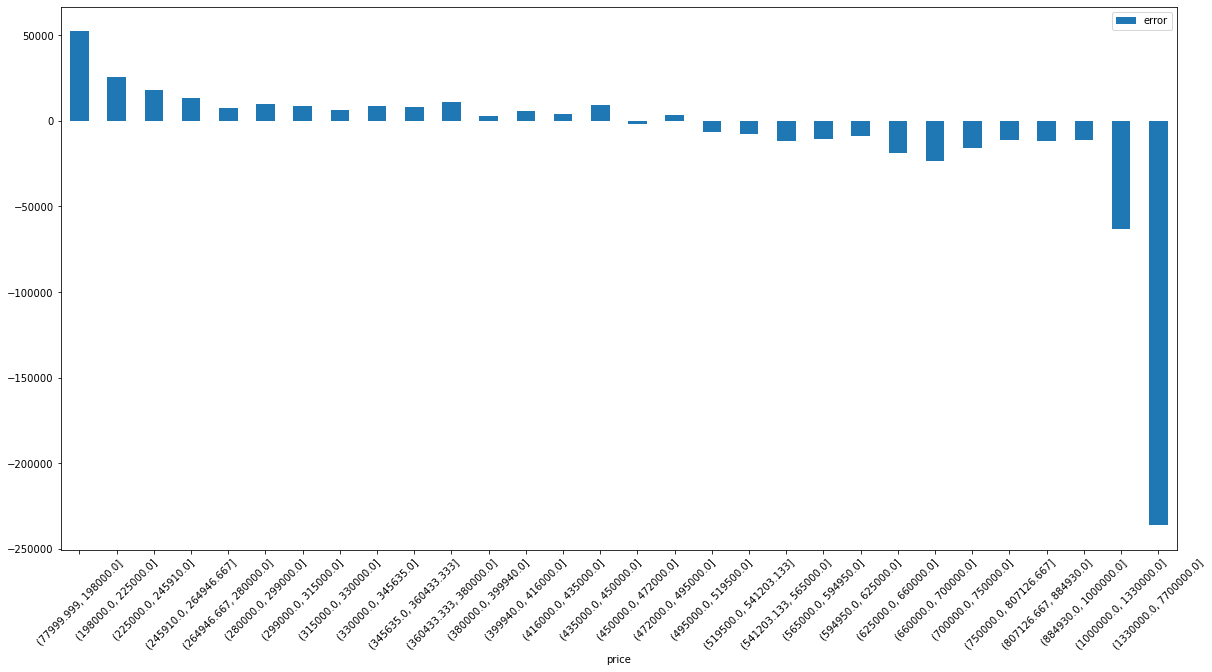

In [20]:
quantile_error(X_train_concat, y_train, 30)

In [67]:
X_train[(np.exp(y_train) < 100000)]




,field_1,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,RE_Score,TotalScore,WeightedTo,PercentESL,MedianHous,PercentPOC,compared_to_neighbors,lot_compared_to_neighbors,empty_lot_space,tract_num
15981,15981,7625700305,6/5/2014,564000,3,1.75,1980,6250,1.0,0.0,...,1.0,7.0,2.333333,4.860739,77760.0,21.585431,1.000000,1.000000,0.316800,10500
9576,9576,1400700150,7/22/2014,730000,4,2.50,3550,35689,2.0,0.0,...,1.0,4.0,1.333333,2.503230,128086.0,18.104005,1.059701,0.999384,0.099470,32311
1212,1212,1026049082,11/25/2014,500000,4,2.00,2760,27631,2.0,0.0,...,1.0,5.0,1.666667,1.516684,106058.0,20.020222,1.108434,2.099939,0.099888,21400
18840,18840,6638900405,12/8/2014,405000,2,1.00,800,6016,1.0,0.0,...,2.0,8.0,2.666667,5.608444,69177.0,25.186258,0.544218,1.611141,0.132979,1702
20748,20748,9536600810,7/8/2014,380000,4,2.50,1984,32400,1.0,0.0,...,4.0,11.0,3.666667,10.023828,70783.0,49.467832,1.427338,3.540210,0.061235,30003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11296,11296,2407900550,5/7/2015,448000,4,2.50,2230,5000,1.0,0.0,...,2.0,6.0,2.000000,4.137727,94844.0,27.220334,1.066986,1.078283,0.446000,31903
11977,11977,1066100260,6/20/2014,681500,5,2.75,3260,11700,1.0,0.0,...,2.0,6.0,2.000000,8.611701,125729.0,29.523074,1.139860,1.000000,0.278632,23000
5397,5397,6918100170,3/19/2015,250000,4,3.00,2250,7882,2.0,0.0,...,4.0,11.0,3.666667,10.023828,70783.0,49.467832,1.451613,1.049814,0.285461,30003
860,860,1723049033,6/20/2014,245000,1,0.75,380,15000,1.0,0.0,...,4.0,11.0,3.666667,13.935250,67103.0,54.956767,0.324786,1.000000,0.025333,27400


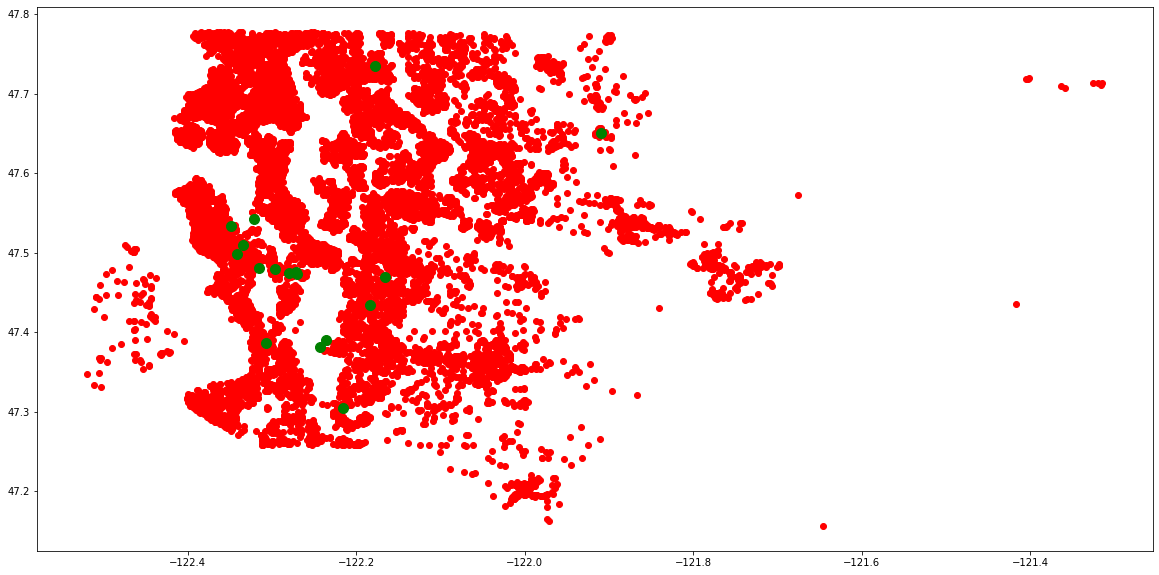

In [21]:
y = X_train.lat
x = X_train.long
plt.scatter(x, y, color='red')
_ = X_train[(np.exp(y_train) < 100000)]
y = _.lat
x = _.long
plt.scatter(x, y, color='green', s=100)

In [69]:
X_train_concat.columns

Index(['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'grade',
       'condition', 'sqft_above', 'bathrooms', 'bedrooms', 'yr_built',
       ...
       'x0_32329', 'x0_32401', 'x0_32402', 'x0_32500', 'x0_32601', 'x0_32602',
       'x0_32702', 'x0_32703', 'x0_32704', 'x0_32800'],
      dtype='object', length=393)

In [70]:
x = X_train['empty_lot_space']

In [71]:
def empty_lot_quartile(X, y, qart):

    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qart))
    #e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['empty_lot_space'] = X['empty_lot_space']
    error_df = quantiles.groupby('price').mean()['empty_lot_space']
    error_df = pd.DataFrame(error_df).reset_index()
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='empty_lot_space', rot=45)
    #figure.plot(figsize = (5,5))
    return figure

<AxesSubplot:xlabel='price'>

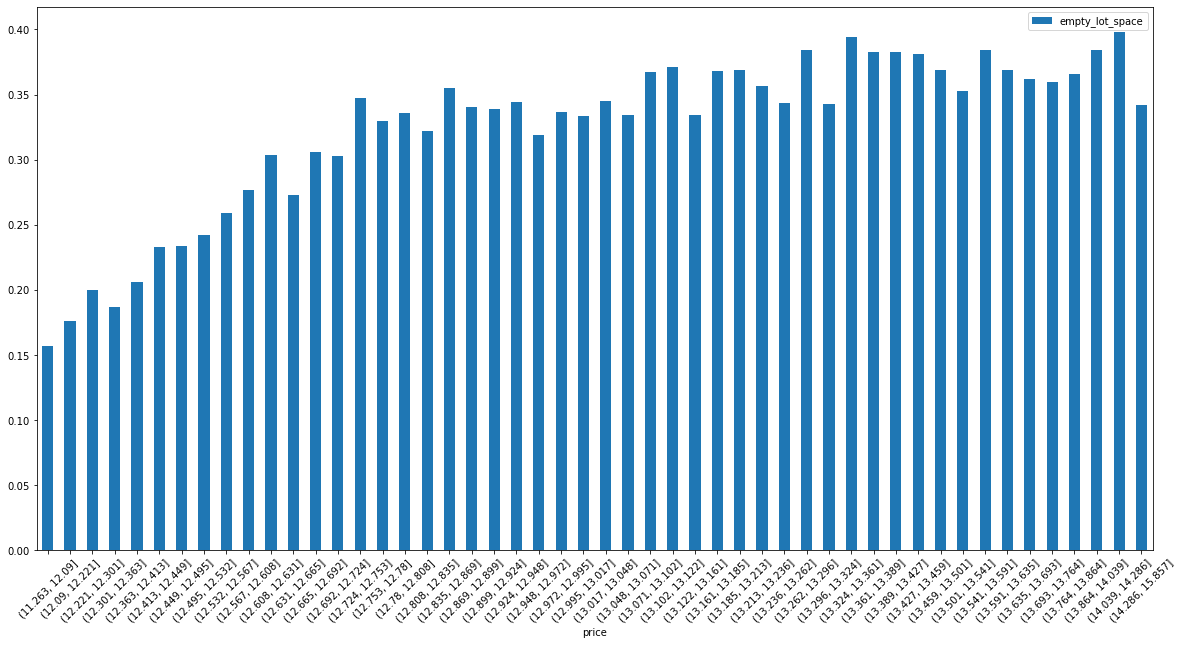

In [72]:
empty_lot_quartile(X_train, y_train, 50)